# Business Understanding

Airbnb, Inc. is an American vacation rental online marketplace company founded in 2008. It maintains and hosts a marketplace, accessible to consumers on its website or via an app.

Airbnb does not own any of the listed properties; instead, it profits by receiving commission from each booking.

The company has attracted criticism for increasing rent prices in cities where it operates. In response, price prediction models, like the one we are going to build here, will help the consumers and company itself to generate alarms if a listing is being made with unjust price.

#### Assiciated Resources:

Medium Article: https://rafayullah.medium.com/airbnb-data-exploration-analysis-and-feature-engineering-edbb47bf115

GitHub Repository: https://github.com/rafayullah/Airbnb

Inside Airbnb: http://insideairbnb.com/get-the-data.html

# Data Understanding

In [1]:
import pandas as pd
import json
import seaborn as sns
from datetime import datetime
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)

In [2]:
class city:
    def __init__(self,name):
        '''
        INPUT:
        name - the name of city

        Takes the name of city as an input and initialises the variables with relevant dataframes.
        The data must be present in the ./Data subfolder.
        '''
        name = './Data/' + name
        self.listings = pd.read_csv(name+'/listings.csv')
        self.calendar = pd.read_csv(name+'/calendar.csv')
        self.reviews = pd.read_csv(name+'/reviews.csv')
        

class operations:
    nlp = spacy.load('en_core_web_lg')
    nlp.add_pipe( SpacyTextBlob() )
    
    def normalize(self,df, cols):
        '''
        INPUT:
        df - pandas pd.DataFrame containg data to normalize
        cols - python list of string containing column names to perform normalization on
        
        OUTPUT:
        df - dataframe with normalized columns
        
        The function takes dataframe and a list of columns as an input.
        After performing normalization, it returns the normalized dataframe
        '''
        df[cols] = df[cols].replace('$', '', regex=True)
        df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())
        return df
    
    def remove_outliers(self,df,col):
        '''
        INPUT:
        df - pandas pd.DataFrame from which the oultliers needs to be removed
        col - a python string having the value of column name
        
        OUTPUT:
        filtered_df - a pandas pd.DataFrame without outliers
        
        The function removes the records having outliers specicified in the input column, against every room_type
        '''
        filtered_df = pd.DataFrame()
        room_types = df.groupby('room_type')
        for room_type, group in room_types:
            temp_df = group[(group[col] < group[col].quantile(0.999))&
                            (group[col] > group[col].quantile(0.001))]
            filtered_df = pd.concat([filtered_df,temp_df])
        return filtered_df

    
    def calculate_days(self,row):
        '''
        INPUT:
        row - pandas pd.Series with two date columns in format '%Y-%m-%d'
        
        OUTPUT:
        int - returns the differece between two datestamps in days as an integer
        
        The function takes a series having two date columns as an input. 
        It calculates the days between the given timestamps
        '''
        FMT = '%Y-%m-%d'
        s1 = row.iloc[0]
        s2 = row.iloc[1]
        tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
        return abs(tdelta.days)
    
    def get_sentiment(self,text):
        '''
        INPUT:
        text - python string containing text
        
        OUTPUT:
        series - pandas pd.Series containing two indexes: text polarity as float and list of strong words as list
        
        The function uses spacy for sentiment calculation, it returns the polarity between -1 to 1
        and a list of positive or negative words used in the sentence
        '''
        doc = self.nlp(text)
        polarity = doc._.sentiment.polarity
        subjectivity = doc._.sentiment.subjectivity
        assessments = doc._.sentiment.assessments
        
        words = []
        for assessment in assessments:
            if (polarity < 0) & (assessment[1] < 0):
                words.extend(assessment[0])
            elif (polarity > 0) & (assessment[1] > 0):
                words.extend(assessment[0])
                
        return pd.Series([polarity, words])

operation = operations()
boston = city('boston')

# Removing comma and currency sign from column price
boston.listings.price = boston.listings.price.str.replace(r'[$,]','',regex=True).astype('float') # Removes special characters

# Removing outliers from dataframe based on price against every room_type
boston.listings = operation.remove_outliers(boston.listings,'price')

# Removing comma and currency sign from column price
boston.calendar.price = boston.calendar.price.str.replace(r'[$,]','',regex=True).astype('float') # Removes special characters

# Converting date to pandas format
boston.calendar.date = pd.to_datetime(boston.calendar.date)


### Question: Average number of listings throughout the year

Figure shows the average price of listings throughout the year


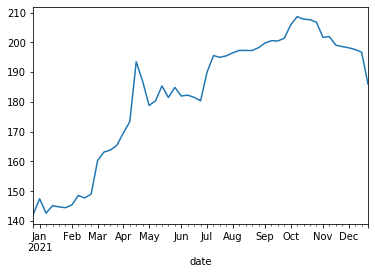

In [3]:
t = boston.calendar.groupby(pd.Grouper(key="date",freq="1W"))['price'].mean()[:-1].plot()
print('Figure shows the average price of listings throughout the year')

### Question: Correlation existence between the average number of listings and price throughout the year

In [4]:
stats_calendar = boston.calendar.groupby(pd.Grouper(key="date",freq="1W"))['price'].agg({'price':'mean',
                                                                                         'listing_id':'nunique'})
stats_calendar.reset_index(inplace=True)
stats_calendar.rename(columns={'price':'average_price','listing_id':'total_listings'},inplace=True)
stats_calendar = operation.normalize(stats_calendar,['average_price','total_listings'])
stats_calendar = stats_calendar[ stats_calendar.total_listings>0]

Figure shows the correlation between the number of listings and average price


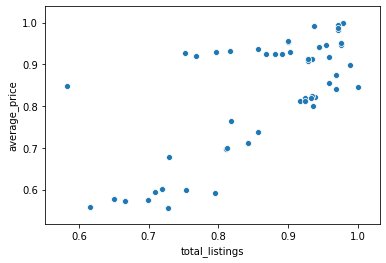

In [5]:
g = sns.scatterplot(data=stats_calendar, x="total_listings", y="average_price")
print('Figure shows the correlation between the number of listings and average price')

In [6]:
stats = boston.listings.groupby(['neighbourhood_cleansed','room_type'])['price'].agg(['mean','std','count'])
stats.reset_index(inplace=True)
stats.head(5)

,neighbourhood_cleansed,room_type,mean,std,count
0,Allston,Entire home/apt,167.246154,165.415200,65
1,Allston,Private room,66.741176,23.424221,85
2,Allston,Shared room,30.000000,NaN,1
3,Back Bay,Entire home/apt,175.098837,147.813129,172
4,Back Bay,Hotel room,143.333333,13.291601,6


### Questtion: Average listing price in neighbourhoods per room type

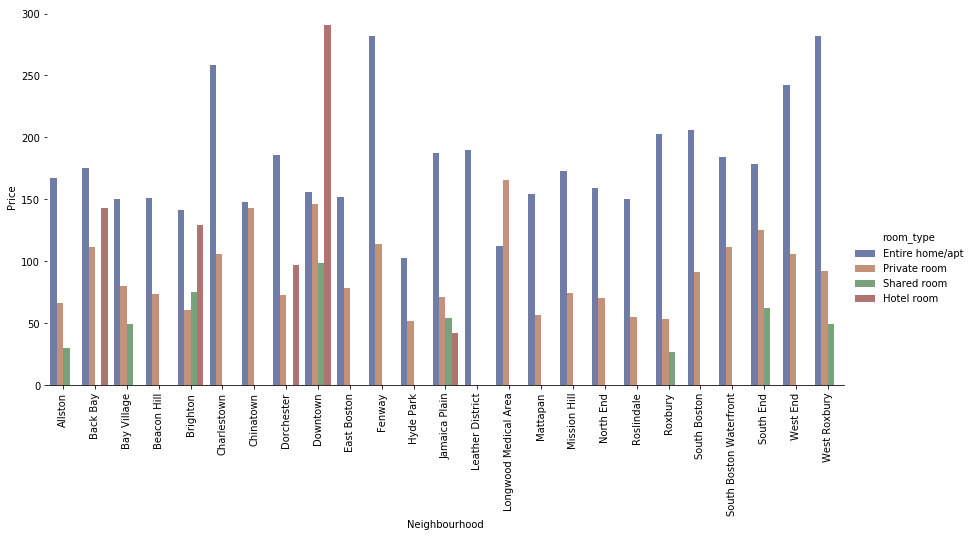

In [7]:
# Draw a nested barplot
g = sns.catplot(data=stats, kind="bar",
                x="neighbourhood_cleansed", y="mean", hue="room_type", 
                ci="sd", palette="dark", alpha=.6, height=6,aspect=2)
g = g.despine(left=True)
g = g.set_axis_labels("Neighbourhood", "Price")
g = g.set_xticklabels(rotation=90)

### Question: Standard deviation among listing price of room types across neighbourhoods

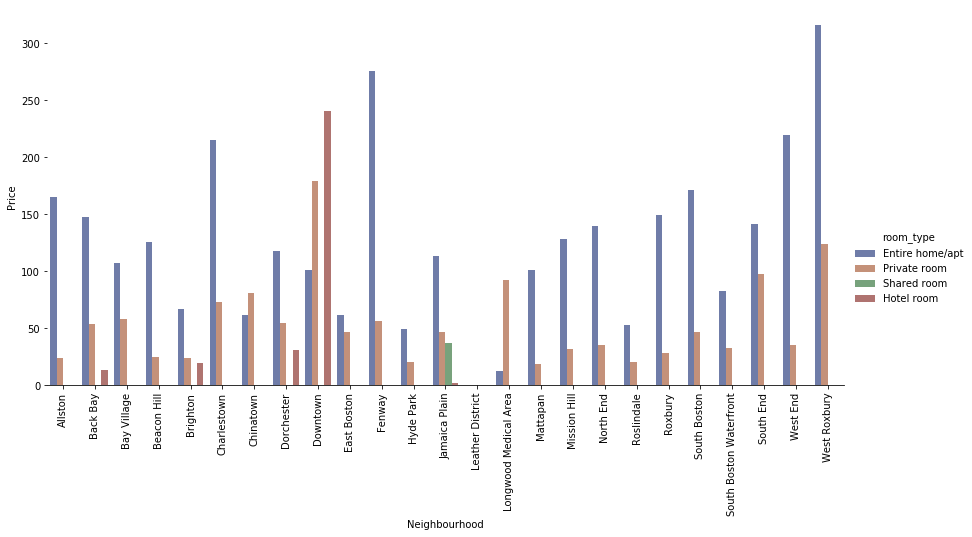

In [8]:
# Draw a nested barplot
g = sns.catplot(data=stats, kind="bar",
                x="neighbourhood_cleansed", y="std", hue="room_type", 
                ci="sd", palette="dark", alpha=.6, height=6,aspect=2)
g = g.despine(left=True)
g = g.set_axis_labels("Neighbourhood", "Price")
g = g.set_xticklabels(rotation=90)

# Data Preparation

### Feature selection and interpolation

In [9]:
cols = ['host_since','last_scraped','host_verifications','calculated_host_listings_count',
        'bedrooms','accommodates','beds','minimum_nights','maximum_nights',
        'neighbourhood_cleansed','room_type',
        'number_of_reviews','reviews_per_month','review_scores_rating',
        'price',
       'host_response_rate','host_acceptance_rate']

dataset = boston.listings.copy()[cols]

# Filling empty values with the mean
dataset = dataset.fillna(dataset.mean())

### Feature manipulation deduction and encoding

In [10]:
# Converting bedrooms type from float to int
dataset.bedrooms = dataset.bedrooms.astype('int')

# Remove characters from numerical features for casting as numerical
dataset.host_response_rate = dataset.host_response_rate.str.replace('%','').astype('float')
dataset.host_acceptance_rate = dataset.host_acceptance_rate.str.replace('%','').astype('float')

# Adding a feature to depict ad posters presence on platform in days since the ad
dataset['host_since_days'] = dataset[['host_since','last_scraped']].apply(operation.calculate_days,axis=1)
dataset.drop(columns=['host_since','last_scraped'],inplace=True)


def get_unique_features(df, column):
    '''
    INPUT:
    df - pandas pd.DataFrame containg the column, the column must contain a list for every record. 
         For reference look at the column amenities and host_verifications
    columns - python string containing a column name
    
    OUTPUT:
    unique_features - python list containing all unique occurrences present in the specified column
    
    The function returns the unique values present in a dataframe column that have list of values for each record
    '''
    unique_list = df[column].unique().tolist()
    unique_features = list()
    for i in unique_list:
        unique_features.extend(eval(i))
        unique_features = list(set(unique_features))
    print('{} column contains {} unique features'.format(column,len(unique_features)))
    print('{} features parsed and added'.format(column))
    return unique_features

def get_list_as_features(lst):
    '''
    INPUT:
    lst - takes a string list as an input, for example: '['hello','world']'
    
    OUTPUT:
    series - pandas pd.Series containing the list as features
    
    The function returns the features in a pandas.Series. 
    The function must be run after the function 'get_unique_features'.
    It uses the 'unique_features' returned from the 'get_unique_features' function.
    '''
    lst = eval(lst)
    series = pd.Series( index=unique_features,data=0 )
    series[lst] = 1
    return series

# Parsing the column 'host_verifications' into features (similar steps can be performed with 'amenities')
unique_features = get_unique_features(dataset, 'host_verifications')
dataset[unique_features] = dataset.host_verifications.apply(get_list_as_features)
dataset.drop(columns=['host_verifications'],inplace=True)

host_verifications column contains 18 unique features
host_verifications features parsed and added


### Encoding Categorical Features

In [11]:
# Getting encodings for categorical variables
cat_cols = dataset.columns.unique()[dataset.dtypes == 'object'].tolist()
num_cols = dataset.columns.unique()[dataset.dtypes != 'object'].tolist()


encoded = pd.get_dummies(dataset[cat_cols],drop_first=True).astype('int')
dataset = pd.concat([dataset[num_cols],encoded],axis=1)

# Final data shape
print(dataset.shape)

(3092, 58)


# Data Modeling

### Model data split, training and validation

In [12]:
from sklearn.model_selection import train_test_split

X = dataset.iloc[:,dataset.columns != 'price']
y = dataset['price']

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)

In [13]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Create instace
xgb_reg = xgb.XGBRegressor(learning_rate=0.07,n_estimators=100,
                           gamma=5,colsample_bytree=0.3,subsample=0.5)

# Fit the model on training data
xgb_reg.fit(X_train, y_train)

# Predict
training_preds_xgb_reg = xgb_reg.predict(X_train)

# Validate
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 2904.0726
Validation MSE: 8166.4517

Training r2: 0.8304
Validation r2: 0.5349


## Evaluation

#### Training set performance visualization

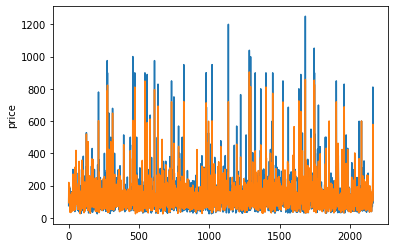

In [14]:
p = sns.lineplot(x=range(len(y_train)),y=y_train) # Blue
p = sns.lineplot(x=range(len(training_preds_xgb_reg)),y=training_preds_xgb_reg) # Orange

#### Validation set performance visualization

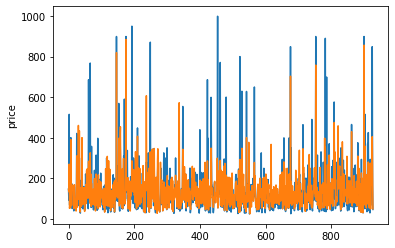

In [15]:
p = sns.lineplot(x=range(len(y_test)),y=y_test) # Blue
p = sns.lineplot(x=range(len(val_preds_xgb_reg)),y=val_preds_xgb_reg) # Orange

### Feature importance

In [16]:
feature_importance = pd.DataFrame(data = {'features':X.columns,'importance':xgb_reg.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False).reset_index(drop=True)
feature_importance

,features,importance
0,room_type_Private room,0.140501
1,bedrooms,0.067701
2,accommodates,0.059843
3,beds,0.044354
4,neighbourhood_cleansed_Charlestown,0.033762
5,neighbourhood_cleansed_Fenway,0.032942
6,neighbourhood_cleansed_West End,0.027038
7,neighbourhood_cleansed_West Roxbury,0.025756
8,neighbourhood_cleansed_Back Bay,0.025512
9,jumio,0.024916


# Future Model Improvements

### Sentiment Analysis

In [17]:
sentiments_df = pd.DataFrame(data={'text':boston.reviews.comments[:10]})
sentiments_df[['polarity','strong_words']] = sentiments_df.text.apply(operation.get_sentiment)
sentiments_df

,text,polarity,strong_words
0,The apartment was as advertised and Frank was ...,0.300000,[incredibly]
1,It was a pleasure to stay at Frank's place. Th...,-0.150000,[base]
2,The apartment description is entirely faithful...,0.134375,"[very, very, nice, very]"
3,Thoroughly enjoyed my time at Frank's home. Ha...,0.387667,"[enjoyed, very, clean, very, happy, great, fan..."
4,Great value for the money! This location has e...,0.225000,"[great, !, very, really, free, !, very, calm, ..."
5,Frank was very accommodating throughout my sta...,0.281944,"[very, easy, detailed, seamless, clear, clean, !]"
6,Excellent! This was my second stay at the Jeff...,0.266667,"[excellent, !, extraordinarily]"
7,Frank was a wonderful and accommodating host. ...,0.433500,"[wonderful, exactly, very, clean, smooth, easy..."
8,"Frank was great, the apartment has everything ...",0.790625,"[great, lovely, !, !]"
9,Very nice. Comfortable apartment. Good locatio...,0.665000,"[very, nice, comfortable, good, very, nice]"


In [18]:
# Here you can see the Spacy making mistake classifying 'base' as a negative word
operation.get_sentiment("base")

0      -0.8
1    [base]
dtype: object